In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig

sys.path.append('..')
from libs.constants import * 
from libs.load_bat_line import *

In [2]:
def load_bin_tracks(path, channel=32):
    f = np.fromfile(str(path), dtype=np.int16)
    tracks = f.reshape(int(f.shape[0]/channel), channel)[:, :16].T
    return tracks

In [5]:
sample_freq = 500e3
mov_fps = 30
mov_frame_count = 300

temperature = 28
sound_velocity = 331.5 + 0.6 * temperature

max_space_length = np.sqrt(4.5**2 + 9**2) 
same_time_range = max_space_length / sound_velocity

bat_ids = ['bat290', 'bat294', 'bat296', 'bat298']
start_stop = [(160, 191), (240, 270), (189, 225), (190, 232)]
numbers = [1, 2, 3, 5]

no = 3

In [6]:
calib_tracks = load_bin_tracks(raw_sound_190526_path / 'no1.bin')

tracks = load_bin_tracks(raw_sound_190526_path / bat_ids[3] / f'no{numbers[no]}.bin')

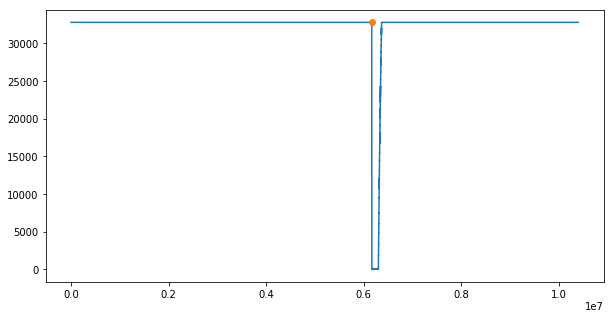

In [7]:
start_frame_num, stop_frame_num = start_stop[no]

trigger_ind = np.where(tracks[0, :]<30000)[0][0]
trigger_sec = trigger_ind / sample_freq

start_ind = int(trigger_ind - sample_freq * (mov_frame_count - start_frame_num) / mov_fps)
stop_ind = int(trigger_ind - sample_freq * (mov_frame_count - stop_frame_num) / mov_fps)

cropped_tracks = tracks[:, start_ind:stop_ind]

plt.figure(figsize=(10, 5))
plt.plot(tracks[0, :])
# plt.plot(range(trigger_ind, trigger_ind+1000), 20000*np.ones(1000), 'o')
plt.plot(trigger_ind, tracks[0, 0], 'o')
plt.show()

In [8]:
print(tracks.shape[1] / sample_freq)
print(trigger_ind/sample_freq)

20.8
12.328178


(16, 700000)


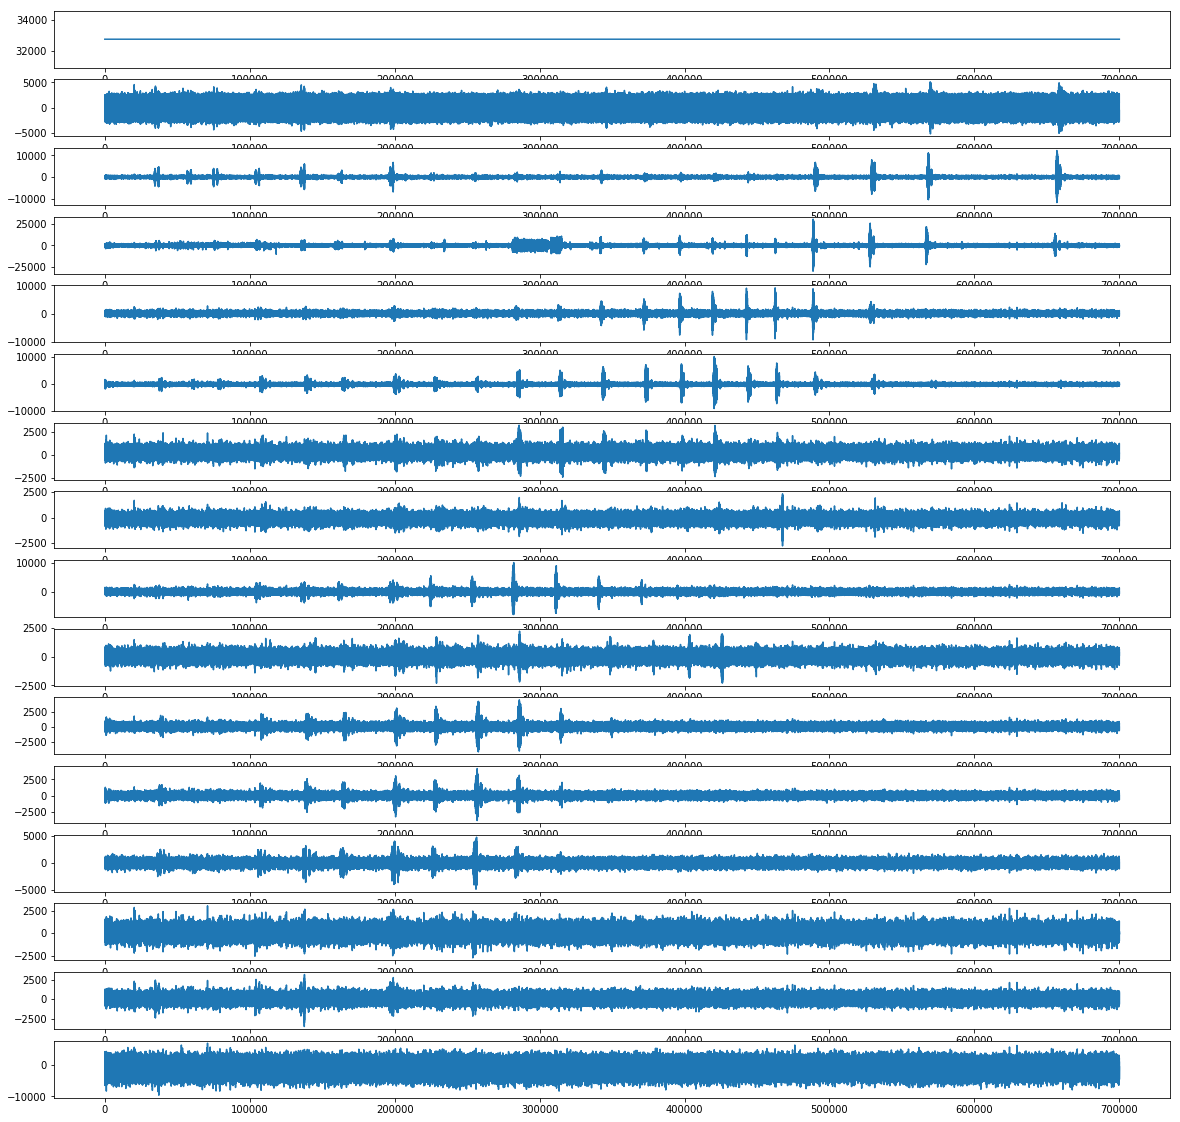

In [9]:
def show_tracks(tracks, start=0, stop=-1): 
    amp_max = max(-np.min(tracks[1:]), np.max(tracks[1:]))
    plt.figure(figsize=(20, 20), facecolor='white')
    for i in range(16):
        plt.subplot(16, 1, i+1)
#         plt.plot(tracks[i, 2400000:2500000])
        plt.plot(tracks[i])
#         plt.ylim([-amp_max, amp_max])
    plt.show()
    
    
def extract_signal(raw_tracks, calib_tracks):
    noise = calib_tracks[1:16, :50000]
#     return np.vstack((raw_tracks[0], raw_tracks[1:16] / np.max(noise, axis=1).reshape(15, 1)))
    return np.where(raw_tracks<=np.max(noise), 0, raw_tracks)


signal = extract_signal(cropped_tracks, calib_tracks)
print(signal.shape)
show_tracks(cropped_tracks)
# show_tracks(signal)

In [10]:
def convert_spectrogram(audio_tracks, sample_frequency=500e3):
    spectro = []
    for i, track in enumerate(audio_tracks):
        f, t, Sxx = sig.spectrogram(track, fs=500e3, nperseg=2**8)
        spectro.append(Sxx)
    return np.array(spectro), f, t

In [11]:
spects, f, t = convert_spectrogram(cropped_tracks)

In [12]:
def show_spect(spect):
    plt.figure(figsize=(20, 40), facecolor='white')
    plt.subplot(spect.shape[0], 1, i+1)
    plt.pcolormesh(t, f, spect, cmap='magma')
    plt.ylim([40e3, 80e3])
    plt.xlabel('[sec]')
    plt.ylabel('[Hz]')
    plt.show() 

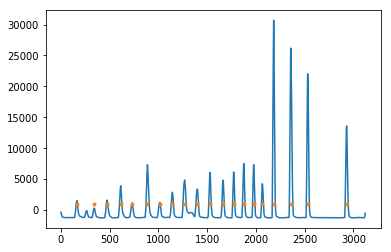

20


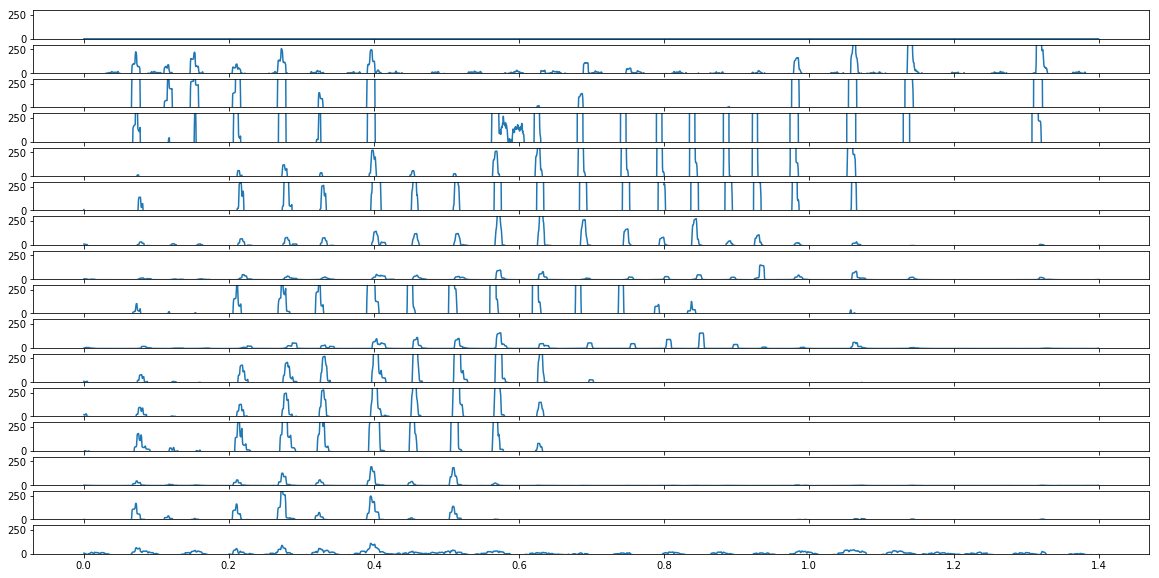

In [22]:
def sum_freq(spectrograms, freqs, band=(45000, 70000)):
    band_sums = []
    lower_ind = np.where(freqs >= band[0])[0][0]
    upper_ind = np.where(freqs <= band[1])[0][-1]
    
    for i, spectro in enumerate(spectrograms):
        band_sum = np.average(spectro[lower_ind:upper_ind], axis=0)
        band_sum = band_sum - np.average(band_sum)
        band_sum = np.convolve(band_sum, np.ones(15), mode='same')
        band_sums.append(band_sum)
        
    return np.array(band_sums)


def pulse_timing(band_sums, thresh=5):
    band_av = np.average(band_sums, axis=0)
    band_av = np.convolve(band_av, np.ones(15), mode='same')
    sub_band_av = band_av[1:] - band_av[:-1]
    
    ind = []
    for i in range(1, band_av.shape[0]-2):
        if band_av[i] > thresh and sub_band_av[i] > 0 and sub_band_av[i+1] < 0:
            ind.append(i+1)
    plt.plot(band_av)
#     plt.plot(sub_band_av)
    plt.plot(ind, 1000*np.ones(len(ind)), '.')
    plt.show()
    
    print(len(ind))
    return np.array(ind)


band_sums = sum_freq(spects, f)
pulse_ind = pulse_timing(band_sums)

plt.figure(figsize=(20, 10), facecolor='white')
for i, spectro in enumerate(band_sums):
    plt.subplot(band_sums.shape[0], 1, i+1)
    plt.plot(t, spectro)
    plt.ylim([0, 300])
plt.show()

In [14]:
mic_points = np.array(
    [[4.5, z] for z in range(4, 9)] + \
    [[4.1, 9], [3.3, 9], [2.7, 7.5], [1.8, 9], [0.9, 9]] + \
    [[0, 8-z] for z in range(5)]
)

xls_sheets_path = processed_path / '190526'

no1_xyzt = load_xyz_from_exl(xls_sheets_path / 'no1_bat298.xls')
no2_xyzt = load_xyz_from_exl(xls_sheets_path / 'no2_bat298.xls')
no3_xyzt = load_xyz_from_exl(xls_sheets_path / 'no3_bat298.xls')
no5_xyzt = load_xyz_from_exl(xls_sheets_path / 'no5_bat298.xls')

no1_xyzt.head()

def preprocess(df):
    d = {
        'x': polyfit(df['t'][:-1], df['x'][:-1]),
        'y': polyfit(df['t'][:-1], df['y'][:-1]),
        'z': polyfit(df['t'][:-1], df['z'][:-1]),
        't': df['t'][:-1]
    }
    return pd.DataFrame(data=d)

no1_xyzt = preprocess(no1_xyzt)
no2_xyzt = preprocess(no2_xyzt)
no3_xyzt = preprocess(no3_xyzt)
no5_xyzt = preprocess(no5_xyzt)

xyzt = [
    no1_xyzt, 
    no2_xyzt, 
    no3_xyzt, 
    no5_xyzt, 
]

../libs/load_bat_line.py:32: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x[:-1], y[:-1], 10)
../libs/load_bat_line.py:32: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x[:-1], y[:-1], 10)
../libs/load_bat_line.py:32: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x[:-1], y[:-1], 10)


(43,) (43,)


/home/lee/.pyenv/versions/3.7.0/envs/jupyter_bat/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/home/lee/.pyenv/versions/3.7.0/envs/jupyter_bat/lib/python3.7/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys


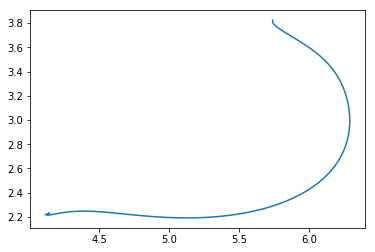

In [15]:
def complement_bat_line(df, band_sums, frame_start, frame_stop):
    x, z = df['x'], df['z']
    frame_num = np.arange(frame_start, frame_stop+1)
    print(x.shape, frame_num.shape)
    
    coef_x = np.polyfit(frame_num, x, 10)
    coef_z = np.polyfit(frame_num, z, 10)
    
    fx = np.poly1d(coef_x)
    fz = np.poly1d(coef_z)
    
    t_ = np.linspace(frame_start, frame_stop, num=band_sums.shape[1])
    return fx(t_), fz(t_), t_


x, z, t_comp = complement_bat_line(xyzt[no], band_sums, start_frame_num, stop_frame_num)

x = 4.5 - (x + 1000) / 1000
z = 9 - (3000 - z) / 1000

plt.plot(z, x)

(15, 3124, 2) (16, 3124)
(3124, 2)


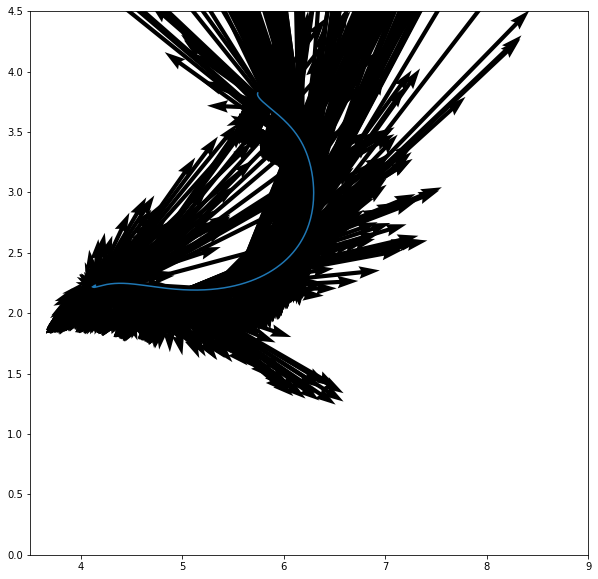

In [16]:
def cal_vectors_to_mic(x, z, t, mic_points):
    vectors = []
    for mic_point in mic_points:
        mic_x, mic_z = mic_point
        vec_x, vec_z = mic_x - x, mic_z - z
        vector = np.array([vec_z, vec_x]).T
        vector_lengths = np.sqrt(vec_z**2 + vec_x**2).reshape(vector.shape[0], 1)
        unit_vector = vector / vector_lengths
        vectors.append(unit_vector)
    return np.array(vectors)


def sum_weighted_vectors(vectors, weights):
    w_vectors = []
    for v, w in zip(vectors, weights):
        w_v = v * w.reshape(w.shape[0], 1)
        w_vectors.append(w_v)
    return np.sum(w_vectors, axis=0)


vectors = cal_vectors_to_mic(x, z, t, mic_points)
print(vectors.shape, band_sums.shape)
    
use_channels = np.array([4, 7, 8, 9, 10, 11, 12, 13])
w_vectors = sum_weighted_vectors(vectors, band_sums[1:])
plt.figure(figsize=(10, 10), facecolor='white')
plt.plot(z, x)

for i in range(0, z.shape[0], 1):
    plt.quiver(z[i], x[i], w_vectors[i, 0], w_vectors[i, 1], scale=10000)

print(w_vectors.shape)
# 0], w_vectors[i, 1], scale=10000)

plt.ylim([0, 4.5])
plt.xlim([3.5, 9])
plt.show()

In [27]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

def line_2d_plot(df, s_or_a=None): 
    '''
    plot line 2D
    
    parameters
    ----------
    df: pandas DataFrame
    s_or_a: int, 1 or 2 means 'speed' or 'acceleration'.
    '''
    xs = 4.5 - (df['x'] + 1000) / 1000
    zs = 9 - (3000 - df['z']) / 1000
    xs = np.array(xs[:-1])
    zs = np.array(zs[:-1])

    fig = plt.figure(figsize=(9, 7), facecolor='white')
    plt.plot(zs[0], xs[0], 'o' , color='orange')
    
    if s_or_a in [1, 2]:
        dt = np.abs(df['t'][1] - df['t'][0])
        ds = cal_derivative(xs, zs, dt, s_or_a)
        
        brake_points = []
        for i in range(len(ds)-1):
            if ds[i+1] < 0 and ds[i] > 0:
                brake_points.append(i)
        brake_points = np.array(brake_points)
            
            
        mymap = LinearSegmentedColormap.from_list('rainbow', ['red', 'blue'])
#         mymap = LinearSegmentedColormap.from_list('gray', ['white', 'black'])
        
        levels = np.linspace(ds.min(), ds.max(), num=100)
#         CS3 = plt.contourf([[0, 0], [0, 0]], levels, cmap='gray')
        CS3 = plt.contourf([[0, 0], [0, 0]], levels, cmap='rainbow')
        plt.clf()
        
        for x1, x2, y1, y2, d in zip(zs[:-1], zs[1:], xs[:-1], xs[1:], ds):
            # setting rgb color based on z normalized to my range
            r = (d - ds.min()) / (ds.max() - ds.min())
#             plt.plot([x1, x2], [y1, y2], color='black', linewidth=r*20+3)
#             plt.plot([x1, x2], [y1, y2], color=cm.gray(r), linewidth=5, alpha=0.5)
            plt.plot([x1, x2], [y1, y2], color=cm.hsv(r), linewidth=5)
        cbar = plt.colorbar(CS3) # using the colorbar info I got from contourf
        cbar.ax.set_ylabel(r'acceleration [m/$\rm s^2$]', rotation=270, position=(0, 0.55))
        for i in brake_points:
            print(i)
            plt.plot(zs[i], xs[i], 'x', color='black', markersize=8)
    else:
        plt.plot(zs, xs)
        
        
    # plot obstacle
    ob_x = np.linspace(2.125 - 0.5, 2.125 + 0.5, 100)
    ob_z = 6.5 * np.ones(100)
    plt.plot(ob_z, ob_x, color='black')

    plt.xlim(3.5, 9)
    plt.ylim(0, 4.5)
    plt.xlabel('distance [m]')
    plt.ylabel('distance [m]')
   
#     plt.show()

(3124, 2)
1
18
36


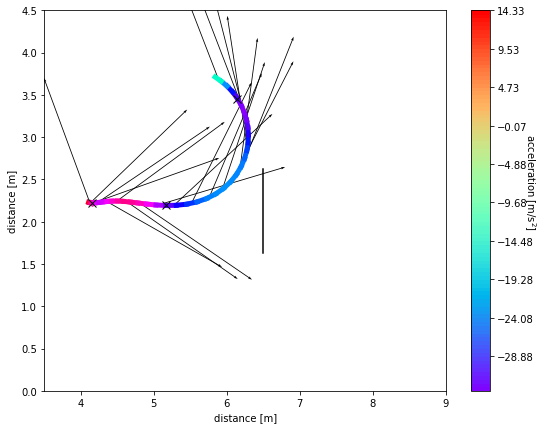

In [28]:
def convert_unit_vectors(vectors):
    lengths = np.sqrt(vectors[:, 0]**2 + vectors[:, 1]**2)
    unit_pulse_vectors = vectors / lengths.reshape(lengths.shape[0], 1)
    return unit_pulse_vectors


def avoid_echo(pulse_vectors, time, avoid_range=0.05): 
    avoid_range_ind = int(avoid_range/time[1]-time[0])
    
    i = 0
    while i < pulse_vectors.shape[0]:
        if pulse_vectors[i, 0] > 0 or pulse_vectors[i, 1] > 0:
            pulse_vectors[i+1:i+avoid_range_ind, :] = 0
            i += avoid_range_ind
        else:
            i += 1
    return pulse_vectors
    
    
def choose_pulses_ind(vectors, n=20):
    lengths = np.sqrt(vectors[:, 0]**2 + vectors[:, 1]**2)
    ind = np.argsort(lengths)
    print(ind)
    return ind[-n:]


def normalize_vector_norms(vectors):
    lengths = np.sqrt(vectors[:, 0]**2 + vectors[:, 1]**2)
    lengths = (lengths - np.min(lengths)) / (np.max(lengths) - np.min(lengths))
    return vectors / lengths.reshape(lengths.shape[0], 1)
    

ind = pulse_ind
 
p_vectors = convert_unit_vectors(w_vectors)
# p_vectors = normalize_vector_norms(w_vectors[ind])
# ind = choose_pulses_ind(w_vectors, n=pulse_ind.shape[0])
print(p_vectors.shape)


line_2d_plot(xyzt[no], s_or_a=2)

plt.quiver(
    z[ind], 
    x[ind], 
    p_vectors[ind, 0], 
    p_vectors[ind, 1], 
    scale=3, color='black', width=0.002)

# plt.plot(z[ind], x[ind], '.', color='white')

plt.ylim([0, 4.5])
plt.xlim([3.5, 9])

plt.savefig(f'fig_no{numbers[no]}_color.png')

In [19]:
ind.shape

(20,)

In [18]:

i = 15
j = 3
-180 * np.arctan((xyzt[j]['x'][i] - xyzt[j]['x'][0])/(xyzt[j]['z'][i] - xyzt[j]['z'][0]))/np.pi

-0.6146420141933439

In [19]:
180*np.arctan(1/np.sqrt(3))/np.pi

30.000000000000004